In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from skimage import io

import warnings
warnings.filterwarnings("ignore")
marks = pd.read_csv('../input/train_ship_segmentations_v2.csv') # Markers for ships
images = os.listdir('../input/train_v2') # Images for training
os.chdir("../input/train_v2")

In [2]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [3]:
def mask_part(pic):
    '''
    Function that encodes mask for single ship from .csv entry into numpy matrix
    '''
    back = np.zeros(768**2)
    starts = pic.split()[0::2]
    lens = pic.split()[1::2]
    for i in range(len(lens)):
        back[(int(starts[i])-1):(int(starts[i])-1+int(lens[i]))] = 1
    return np.reshape(back, (768, 768, 1))

def is_empty(key):
    '''
    Function that checks if there is a ship in image
    '''
    df = marks[marks['ImageId'] == key].iloc[:,1]
    if len(df) == 1 and type(df.iloc[0]) != str and np.isnan(df.iloc[0]):
        return True
    else:
        return False
    
def masks_all(key):
    '''
    Merges together all the ship markers corresponding to a single image
    '''
    df = marks[marks['ImageId'] == key].iloc[:,1]
    masks= np.zeros((768,768,1))
    if is_empty(key):
        return masks
    else:
        for i in range(len(df)):
            masks += mask_part(df.iloc[i])
        return np.transpose(masks, (1,0,2))

Randomly chosen images with corresponding masks


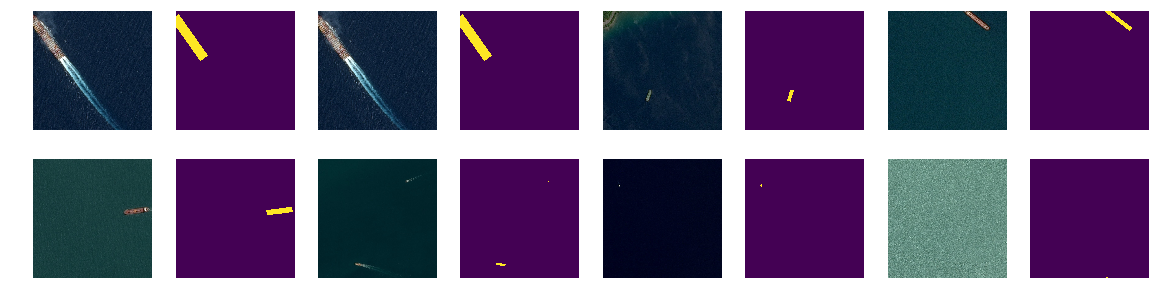

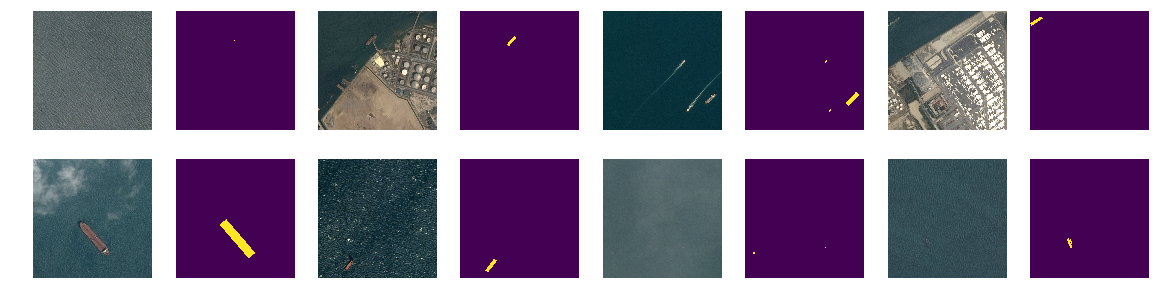

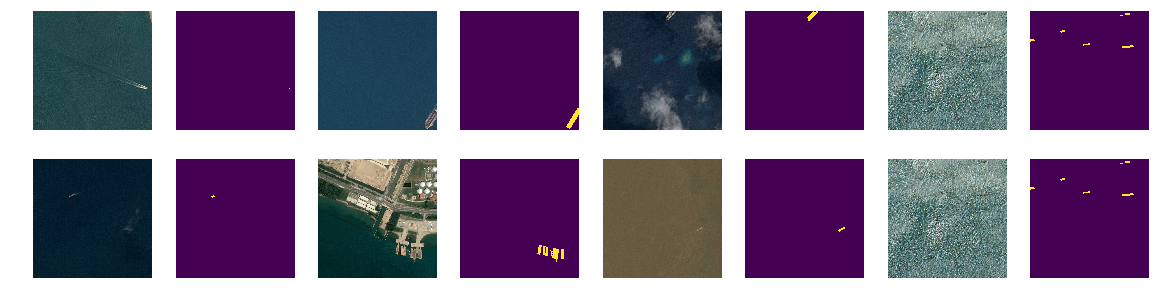

In [4]:
def draw(lista):
    l = int(len(lista)/2)
    plt.figure(figsize = (20,5))
    for i in range(2*l):
        plt.subplot(2,2*l,2*i+1)
        plt.imshow(plt.imread(lista[i]))
        plt.axis('off')
        plt.subplot(2,2*l,2*i+2)
        plt.imshow(masks_all(lista[i])[:,:,0])
        plt.axis('off')
        #plt.suptitle('Images and corresponding masks', fontsize = 22)
    plt.show()
print('Randomly chosen images with corresponding masks')
draw(np.random.choice([i for i in images[:200] if not is_empty(i)], size = 8))
draw(np.random.choice([i for i in images[200:400] if not is_empty(i)], size = 8))
draw(np.random.choice([i for i in images[400:600] if not is_empty(i)], size = 8))

In [5]:
def make_batch(files, batch_size):
    '''
    Creates batches of images and masks in order to feed them to NN
    '''
    X = np.zeros((batch_size, 768, 768, 3), dtype=np.float32)
    Y = np.zeros((batch_size, 768, 768, 1), dtype=np.float32) # I add 1 here to get 4D batch
    for i in range(batch_size):
        ship = np.random.choice(files)
        X[i] = (io.imread(ship))#/255.0 # Original images are in 0-255 range, I want it in 0-1
        Y[i] = masks_all(ship)
    return X, Y

In [6]:
X, Y = make_batch(images, 10)

In [7]:
X[0,...,0].shape

(768, 768)

In [8]:
Y[0,...,0].shape

(768, 768)

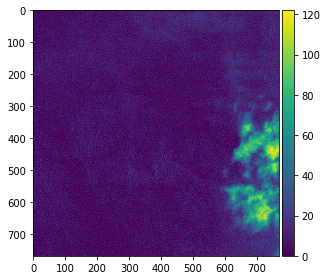

In [9]:
io.imshow(X[0,...,0])

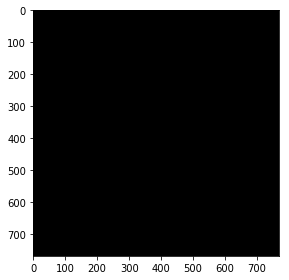

In [10]:
io.imshow(Y[0,...,0])

In [11]:
Z = np.zeros((1, 768, 768, 3), dtype=np.float32)
for i in range(1):
    ship = np.random.choice(images)
    Z[i] = io.imread(ship)

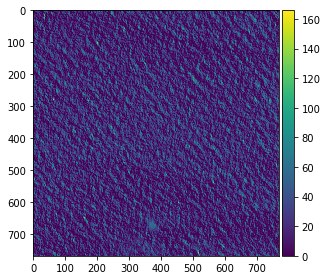

In [12]:
io.imshow(Z[0,...,0])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.2)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((8, 768, 768, 3), (2, 768, 768, 3), (8, 768, 768, 1), (2, 768, 768, 1))

In [14]:
Z=Z[:1]
Z.shape

(1, 768, 768, 3)

In [15]:
X.dtype

dtype('float32')

In [16]:
Y.dtype

dtype('float32')

In [17]:
Y[:5]

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [18]:
Y=Y.astype(bool)

In [19]:
Y[:5].shape

(5, 768, 768, 1)

# Models

In [20]:
def deconv2d(input_tensor, filter_size, output_size, out_channels, in_channels, name, strides = [1, 1, 1, 1]):
    dyn_input_shape = tf.shape(input_tensor)
    batch_size = dyn_input_shape[0]
    out_shape = tf.stack([batch_size, output_size, output_size, out_channels])
    filter_shape = [filter_size, filter_size, out_channels, in_channels]
    w = tf.get_variable(name=name, shape=filter_shape)
    return tf.nn.conv2d_transpose(input_tensor, w, out_shape, strides, padding='VALID')

def conv2d(input_tensor, depth, kernel, name, strides=(1, 1), padding="VALID"):
    return tf.layers.conv2d(input_tensor, filters=depth, kernel_size=kernel, strides=strides, padding=padding, activation=None, name=name)

In [21]:
def cnn_model_fn(features, labels, mode):
    #labels = labels[:,:,:,0]
    """CNN with five conv layers, and six transpose conv layers."""
    net = conv2d(features, 10, 1, "Y0") #768
    net = tf.nn.relu(net)

    net = conv2d(net, 20, 3, "Y1", strides=(2, 2)) #384
    net = tf.nn.relu(net)

    net = conv2d(net, 25, 2, "Y2", strides=(2, 2)) #192
    net = tf.nn.relu(net)

    net = conv2d(net, 50, 3, "Y3", strides=(2, 2)) #96
    net = tf.nn.relu(net)

    net = conv2d(net, 50, 2, "Y4") #48
    net = tf.nn.relu(net)


    net = deconv2d(net, 1, 94, 50, 50, "Y5_deconv") #48
    net = tf.nn.relu(net)

    net = deconv2d(net, 2, 95, 50, 50, "Y4_deconv") #96
    net = tf.nn.relu(net)

    net = deconv2d(net, 3, 191, 25, 50, "Y3_deconv", strides=[1, 2, 2, 1]) #192
    net = tf.nn.relu(net)

    net = deconv2d(net, 2, 383, 20, 25, "Y2_deconv", strides=[1, 2, 2, 1]) #384
    net = tf.nn.relu(net)

    net = deconv2d(net, 3, 768, 10, 20, "Y1_deconv", strides=[1, 2, 2, 1]) #768

    logits = deconv2d(net, 1, 768, 1, 10, "Y0_deconv") #768
    #logits = tf.nn.softmax(logits, axis=-1)

    
    predictions = {
        'logits': logits#[:,:,:,0]
    }



    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    
    #loss = tf.reduce_sum(tf.multiply(logits[:,:,:,0], labels)) * 2
    #loss = 1 - tf.divide(loss, tf.reduce_sum(tf.add(logits[:,:,:,0], labels)))
    
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=logits)
    
    
    # here we define how we calculate our accuracy
    # if you want to monitor your training accuracy you need these two lines
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions['logits'], name='acc_op')
    tf.summary.scalar('accuracy', accuracy[1])
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        tf.identity(accuracy[1], name='train_accuracy')
        tf.summary.scalar('train_accuracy', accuracy[1])
        eval_metric_ops = {'train_accuracy':accuracy}
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op, eval_metric_ops=eval_metric_ops)
    
    # what evaluation metric we want to show
    tf.identity(accuracy[1], name='val_accuracy')
    tf.summary.scalar('val_accuracy', accuracy[1])
    eval_metric_ops = {'val_accuracy': accuracy}
    # here we define what happens if we call the evaluate method of our estimator
    # with its current settings it will display the loss and the accuracy which we defined earlier
    return tf.estimator.EstimatorSpec(
                mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [22]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_train,
    y=Y_train,
    batch_size=20,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_val,
    y=Y_val,
    shuffle=False,
    num_epochs=2)

In [23]:
OUTDIR = './Unet_Model'

# Create the Estimator
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir=OUTDIR)

# here we start the FileWriter method which will actually save the progress in the folder defined above
file_writer = tf.summary.FileWriter(OUTDIR)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './Unet_Model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f983c5d8f98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [24]:
cnn_classifier.train(
    input_fn=train_input_fn,
    steps=100)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Unet_Model/model.ckpt-215
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 215 into ./Unet_Model/model.ckpt.
INFO:tensorflow:loss = 0.20650019, step = 216
INFO:tensorflow:Saving checkpoints for 288 into ./Unet_Model/model.ckpt.
INFO:tensorflow:Saving checkpoints for 315 into ./Unet_Model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.007097865.


In [25]:
test_images=X[:5]

In [26]:
test_images

array([[[[  0.,  29.,  45.],
         [  4.,  33.,  49.],
         [  8.,  37.,  51.],
         ...,
         [ 14.,  36.,  50.],
         [ 13.,  35.,  49.],
         [ 12.,  34.,  48.]],

        [[  5.,  34.,  50.],
         [  5.,  34.,  50.],
         [  6.,  35.,  49.],
         ...,
         [ 13.,  35.,  49.],
         [ 13.,  35.,  49.],
         [ 12.,  34.,  48.]],

        [[  8.,  37.,  53.],
         [  5.,  34.,  50.],
         [  3.,  32.,  46.],
         ...,
         [ 11.,  33.,  47.],
         [ 11.,  33.,  47.],
         [ 12.,  34.,  48.]],

        ...,

        [[  2.,  30.,  44.],
         [  3.,  31.,  45.],
         [  5.,  33.,  47.],
         ...,
         [ 49.,  64.,  71.],
         [ 52.,  67.,  72.],
         [ 54.,  69.,  74.]],

        [[  4.,  32.,  46.],
         [  5.,  33.,  47.],
         [  5.,  33.,  47.],
         ...,
         [ 50.,  65.,  72.],
         [ 51.,  66.,  71.],
         [ 53.,  68.,  73.]],

        [[  7.,  35.,  49.],
       

In [27]:
Z

array([[[[ 9., 11., 24.],
         [ 4.,  6., 19.],
         [ 1.,  4., 19.],
         ...,
         [ 0.,  3., 20.],
         [ 4.,  7., 22.],
         [ 4.,  6., 21.]],

        [[17., 19., 32.],
         [ 6.,  8., 21.],
         [ 0.,  0., 15.],
         ...,
         [ 2.,  8., 24.],
         [ 6.,  9., 26.],
         [ 3.,  6., 23.]],

        [[37., 39., 52.],
         [17., 19., 32.],
         [ 0.,  3., 15.],
         ...,
         [ 5., 10., 29.],
         [ 7., 13., 29.],
         [ 1.,  7., 23.]],

        ...,

        [[20., 25., 44.],
         [15., 22., 40.],
         [22., 30., 49.],
         ...,
         [20., 31., 53.],
         [23., 35., 59.],
         [16., 31., 54.]],

        [[11., 17., 33.],
         [10., 16., 32.],
         [18., 27., 44.],
         ...,
         [15., 26., 48.],
         [18., 30., 54.],
         [14., 28., 54.]],

        [[12., 15., 30.],
         [10., 16., 32.],
         [22., 31., 48.],
         ...,
         [ 8., 19., 41.],
        

In [28]:
Z = np.zeros((1, 768, 768, 3), dtype=np.float32)
for i in range(1):
    ship = np.random.choice(images)
    Z[i] = io.imread(ship)

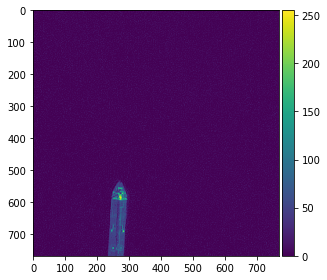

In [29]:
io.imshow(Z[0,...,0])

In [30]:
# Predict input fuction
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=Z,
    batch_size=1,
    shuffle=False)

In [31]:
pred_result = cnn_classifier.predict(input_fn=pred_input_fn)

In [32]:
predicted_mask = next(pred_result)['logits']

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Unet_Model/model.ckpt-315
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [33]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(x))

might need sigmoid for prediction_mask

In [34]:
predicted_mask = np.reshape(np.squeeze(predicted_mask), [768 , 768, 1])
for i in range(768):
        for j in range(768):
                predicted_mask[i][j] = int(sigmoid(predicted_mask[i][j])*255)

In [35]:
predicted_mask = np.reshape(np.squeeze(predicted_mask), [768 , 768, 1])
#for i in range(768):
#        for j in range(768):
#                predicted_mask[i][j] = int((predicted_mask[i][j])*255)

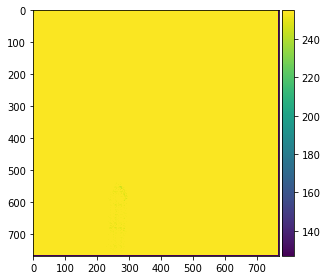

In [36]:
io.imshow(predicted_mask.astype(np.uint8).squeeze())

In [37]:
"""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-37-e4615a684824>, line 1)

## Submission

In [ ]:
from PIL import Image
test_data = np.empty((len(test_v2),256,256,3), dtype=np.float32)
test_data_target = np.empty((len(test_v2)), dtype=np.int32)
image_name_list = test_v2
index = 0
for image_name in image_name_list:
    if image_name in list(test_v2):
        imageA = Image.open('../input/test_v2/' + image_name).resize((256,256)).convert('RGB')
        test_data[index]=imageA
        # prediction
        index+=1

In [ ]:
'''
What the predict_input_fn will do with its current settings is to read the entire inference dataset 
(in order) using batch_size of 128 (default setting). 

Keep in mind that it will also terminate when completes 1 epoch.
'''
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':test_data},
    shuffle=False,
    num_epochs=2)

In [ ]:
generator = cnn_classifier.predict(input_fn=predict_input_fn)

In [ ]:
preds = []
b = []
for i in range(15606):
    a = next(generator)
    preds.append(a['classes'])
    b.append(i)

In [ ]:
res = np.column_stack((test_v2, preds))

In [ ]:
import pandas as pd
df = pd.DataFrame(res)
#df.to_csv('submission_1000pic_20bat_2ep.csv')

In [ ]:
df.columns = ['ImageId', 'EncodedPixels']

In [ ]:
df.drop_duplicates(subset='ImageId',keep=False,inplace=True)

In [ ]:
df.to_csv("submission_final", index=False)